# 利用fbprophet预测新冠疫情期间的供水总量论文

**2020年3月1日prophet预测三月供水总量**

In [186]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
mpl.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime as dt

In [192]:

sup_water = pd.read_excel(r'C:/Users/Jay/mypyworks/自来水数据/2015-2020日供水总量.xlsx')

In [193]:
sup_water

,QUOTA_DATE,最低温度,最高温度,水厂供水总量
0,2015-01-01,15.0,21.0,3941482.0
1,2015-01-02,6.0,20.0,3903494.0
2,2015-01-03,13.0,21.0,4055444.0
3,2015-01-04,8.0,22.0,4077068.0
4,2015-01-05,16.0,23.0,4062857.0
...,...,...,...,...
1893,2020-03-08,20.0,25.0,3904197.0
1894,2020-03-09,22.0,24.0,3963743.0
1895,2020-03-10,17.0,23.0,4092148.0
1896,2020-03-11,14.0,19.0,3999296.0


In [194]:
sup_water = sup_water.set_index('QUOTA_DATE').sort_index()['2017':]

In [190]:
list(sup_water.columns)

['最低温度', '最高温度', '水厂供水总量']

TypeError: float() argument must be a string or a number, not 'Period'

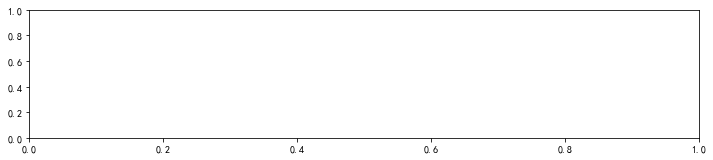

In [191]:
plt.figure(figsize=(12,8))
plt.subplot(311)
sup_water['水厂供水总量'].plot(title='水厂供水总量')
plt.subplot(312)
sup_water['最高温度'].plot(title='最高温度') 
plt.subplot(313)
sup_water['最低温度'].plot(title='最低温度')

In [ ]:
#判断缺失值
# sup_water[sup_water.isnull().any(axis=1)]

# np.isinf(sup_water['最高温度']).value_counts()

In [ ]:
#判断数据框里面所有不是有限数据的数，可以排除null，np.nan,np.inf
sup_water[~(np.isfinite(sup_water).all(axis=1))]

In [195]:
#判断离群值
# print(sup_water['最高温度'].value_counts(dropna=False))
am = sup_water['最低温度'].rolling(window=3,min_periods=1,center=True).mean()
diff = sup_water['最低温度']-am
sup_water[diff.abs()>diff.std(ddof=0)*4]

,最低温度,最高温度,水厂供水总量
QUOTA_DATE,,,


In [196]:
sup_water.eval("平均温度=(最高温度+最低温度)/2",inplace=True)

In [197]:
sup_water.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1167 entries, 2017-01-01 to 2020-03-12
Data columns (total 4 columns):
最低温度      1167 non-null float64
最高温度      1167 non-null float64
水厂供水总量    1167 non-null float64
平均温度      1167 non-null float64
dtypes: float64(4)
memory usage: 45.6 KB


In [198]:
sup_water.corr()

,最低温度,最高温度,水厂供水总量,平均温度
最低温度,1.000000,0.895674,0.453515,0.973473
最高温度,0.895674,1.000000,0.514617,0.973665
水厂供水总量,0.453515,0.514617,1.000000,0.497264
平均温度,0.973473,0.973665,0.497264,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000134EBF4A0C8>,
      dtype=object)

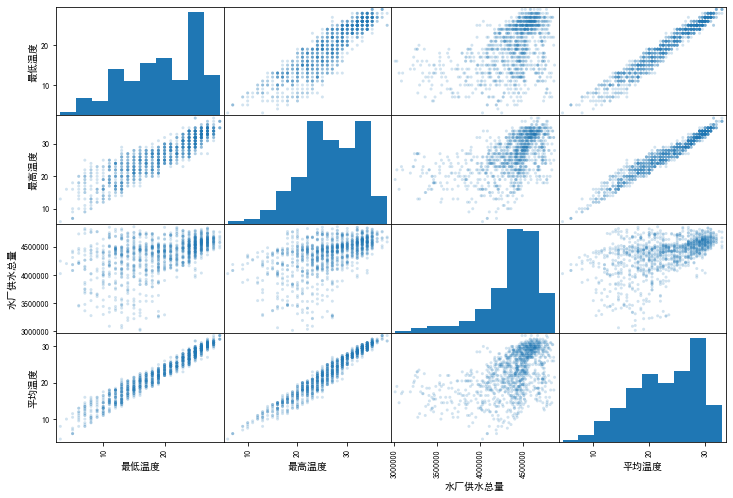

In [199]:
pd.plotting.scatter_matrix(sup_water,figsize=(12,8),alpha=0.2)

In [200]:
sup_water[['最低温度','最高温度','平均温度']]

,最低温度,最高温度,平均温度
QUOTA_DATE,,,
2017-01-01,12.0,24.0,18.0
2017-01-02,15.0,26.0,20.5
2017-01-03,15.0,27.0,21.0
2017-01-04,17.0,24.0,20.5
2017-01-05,16.0,25.0,20.5
...,...,...,...
2020-03-08,20.0,25.0,22.5
2020-03-09,22.0,24.0,23.0
2020-03-10,17.0,23.0,20.0


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3,include_bias=False)
X_poly = poly_features.fit_transform(sup_water[['最低温度','最高温度','平均温度']])

In [ ]:
X_poly.shape

In [ ]:
poly_features.get_feature_names()

In [ ]:
sup_water_poly= pd.DataFrame(data=X_poly,columns=poly_features.get_feature_names())
sup_water_poly

In [ ]:
sup_water_poly['水厂供水总量'] = sup_water['水厂供水总量'].values

In [ ]:
sup_water_poly.corrwith(sup_water_poly['水厂供水总量'])

In [ ]:
#正式运用模型

focastQuota = '水厂供水总量'
sup_water[focastQuota].plot()
plt.title('日供水总量')

In [202]:
sup_water.loc[:'2019-2-1','cap'] = 4450000
sup_water.loc['2019-2-1':,'cap'] = 5050000

In [205]:
sup_water['2019-1-31':'2019-2-1']

,最低温度,最高温度,水厂供水总量,平均温度,cap
QUOTA_DATE,,,,,
2019-01-31,15.0,26.0,4033191.0,20.5,4450000.0
2019-02-01,13.0,18.0,3822936.0,15.5,5050000.0


In [206]:
sup_water_fb = sup_water.reset_index()[['QUOTA_DATE','水厂供水总量','cap']].rename(columns = {'QUOTA_DATE':'ds','水厂供水总量':'y'})

In [217]:
sup_water_fb

,ds,y,cap
0,2017-01-01,4125192.0,4450000.0
1,2017-01-02,4149662.0,4450000.0
2,2017-01-03,4276621.0,4450000.0
3,2017-01-04,4256326.0,4450000.0
4,2017-01-05,4201048.0,4450000.0
...,...,...,...
1162,2020-03-08,3904197.0,5050000.0
1163,2020-03-09,3963743.0,5050000.0
1164,2020-03-10,4092148.0,5050000.0
1165,2020-03-11,3999296.0,5050000.0


In [ ]:
from fbprophet import Prophet

In [110]:
dt.date(2020,3,12)-dt.timedelta(days = 30)

datetime.date(2020, 2, 11)

In [208]:
sup_water_train = sup_water_fb[['ds','y','cap']]
# sup_water_test = sup_water[['ds','y']][-30:]

In [239]:
m = Prophet(changepoint_range=0)
m.fit(sup_water_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using -1.


In [240]:
future = m.make_future_dataframe(periods=760)
future['cap'] = 5050000
forecast = m.predict(future)


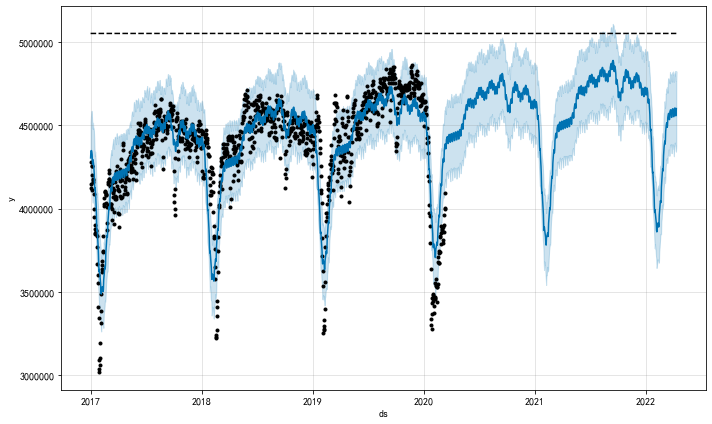

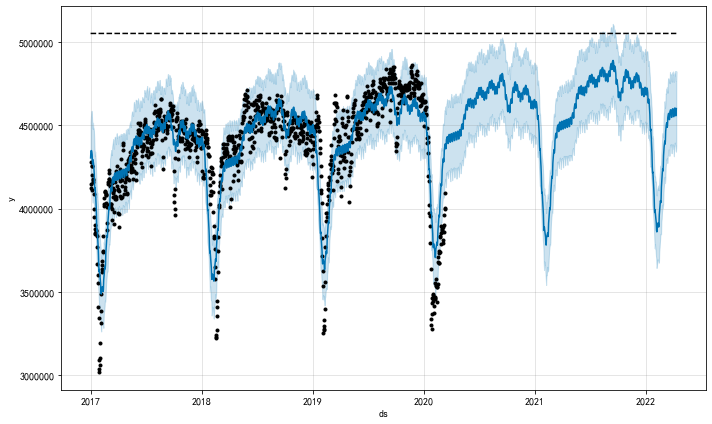

In [241]:
m.plot(forecast)

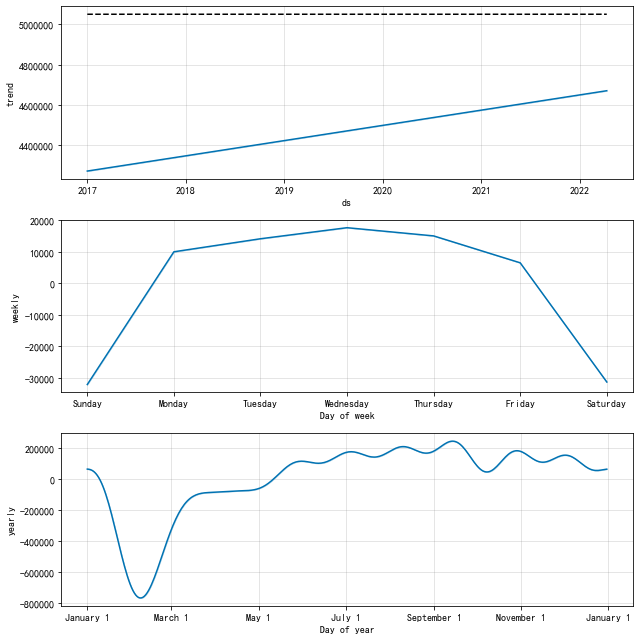

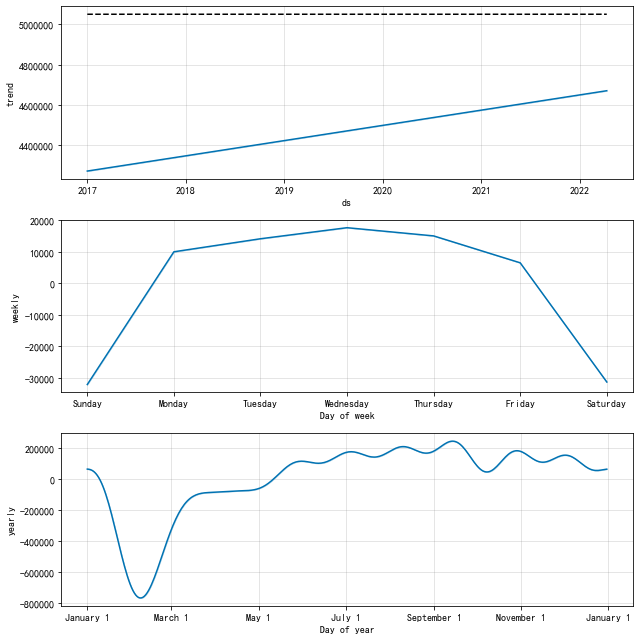

In [242]:
m.plot_components(forecast)

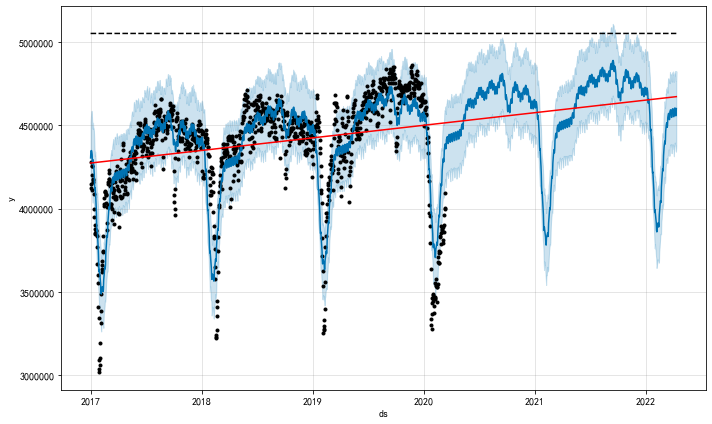

In [243]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
#手动设置 变点

In [175]:
#initial = 365*2,horizon = 365,K=10 ,period=7
dt.date(2020,3,12)-dt.date(2017,1,1)
(1167-730-365)/7

10.285714285714286

In [ ]:
#划分数据 
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='7 days', horizon = '365 days')

In [ ]:
#划分数据 
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='7 days', horizon = '365 days')

In [179]:
df_cv.apply(print,axis=1)

ds            2019-01-03 00:00:00
yhat                  4.44655e+06
yhat_lower            4.26545e+06
yhat_upper             4.6317e+06
y                      4.4428e+06
cutoff        2019-01-02 00:00:00
Name: 0, dtype: object
ds            2019-01-04 00:00:00
yhat                  4.43162e+06
yhat_lower            4.26879e+06
yhat_upper            4.60327e+06
y                     4.43381e+06
cutoff        2019-01-02 00:00:00
Name: 1, dtype: object
ds            2019-01-05 00:00:00
yhat                  4.38757e+06
yhat_lower            4.20786e+06
yhat_upper            4.57016e+06
y                     4.38322e+06
cutoff        2019-01-02 00:00:00
Name: 2, dtype: object
ds            2019-01-06 00:00:00
yhat                  4.37566e+06
yhat_lower            4.19647e+06
yhat_upper            4.55517e+06
y                     4.39813e+06
cutoff        2019-01-02 00:00:00
Name: 3, dtype: object
ds            2019-01-07 00:00:00
yhat                  4.41158e+06
yhat_lower            4.

Name: 160, dtype: object
ds            2019-06-13 00:00:00
yhat                  4.51857e+06
yhat_lower            4.34146e+06
yhat_upper            4.69644e+06
y                     4.55899e+06
cutoff        2019-01-02 00:00:00
Name: 161, dtype: object
ds            2019-06-14 00:00:00
yhat                  4.50626e+06
yhat_lower            4.33688e+06
yhat_upper            4.68467e+06
y                     4.62384e+06
cutoff        2019-01-02 00:00:00
Name: 162, dtype: object
ds            2019-06-15 00:00:00
yhat                  4.46717e+06
yhat_lower            4.28659e+06
yhat_upper            4.64432e+06
y                     4.59715e+06
cutoff        2019-01-02 00:00:00
Name: 163, dtype: object
ds            2019-06-16 00:00:00
yhat                  4.46271e+06
yhat_lower            4.28018e+06
yhat_upper            4.63836e+06
y                     4.54948e+06
cutoff        2019-01-02 00:00:00
Name: 164, dtype: object
ds            2019-06-17 00:00:00
yhat                  4.5

Name: 294, dtype: object
ds            2019-10-25 00:00:00
yhat                  4.52109e+06
yhat_lower            4.34905e+06
yhat_upper            4.69994e+06
y                     4.71185e+06
cutoff        2019-01-02 00:00:00
Name: 295, dtype: object
ds            2019-10-26 00:00:00
yhat                  4.48682e+06
yhat_lower            4.31223e+06
yhat_upper            4.68611e+06
y                     4.64214e+06
cutoff        2019-01-02 00:00:00
Name: 296, dtype: object
ds            2019-10-27 00:00:00
yhat                  4.48489e+06
yhat_lower            4.29375e+06
yhat_upper             4.6776e+06
y                     4.63503e+06
cutoff        2019-01-02 00:00:00
Name: 297, dtype: object
ds            2019-10-28 00:00:00
yhat                  4.53105e+06
yhat_lower             4.3491e+06
yhat_upper            4.71493e+06
y                     4.66819e+06
cutoff        2019-01-02 00:00:00
Name: 298, dtype: object
ds            2019-10-29 00:00:00
yhat                    4

Name: 492, dtype: object
ds            2019-05-18 00:00:00
yhat                  4.44846e+06
yhat_lower            4.27692e+06
yhat_upper            4.63835e+06
y                     4.62318e+06
cutoff        2019-01-09 00:00:00
Name: 493, dtype: object
ds            2019-05-19 00:00:00
yhat                  4.45561e+06
yhat_lower            4.28645e+06
yhat_upper            4.65679e+06
y                     4.64814e+06
cutoff        2019-01-09 00:00:00
Name: 494, dtype: object
ds            2019-05-20 00:00:00
yhat                  4.51189e+06
yhat_lower             4.3318e+06
yhat_upper            4.69268e+06
y                     4.55438e+06
cutoff        2019-01-09 00:00:00
Name: 495, dtype: object
ds            2019-05-21 00:00:00
yhat                  4.52809e+06
yhat_lower            4.36675e+06
yhat_upper            4.71765e+06
y                     4.52007e+06
cutoff        2019-01-09 00:00:00
Name: 496, dtype: object
ds            2019-05-22 00:00:00
yhat                  4.5

Name: 659, dtype: object
ds            2019-11-01 00:00:00
yhat                  4.53006e+06
yhat_lower            4.33981e+06
yhat_upper            4.71593e+06
y                     4.74043e+06
cutoff        2019-01-09 00:00:00
Name: 660, dtype: object
ds            2019-11-02 00:00:00
yhat                  4.48722e+06
yhat_lower            4.31074e+06
yhat_upper            4.67743e+06
y                     4.70871e+06
cutoff        2019-01-09 00:00:00
Name: 661, dtype: object
ds            2019-11-03 00:00:00
yhat                   4.4775e+06
yhat_lower            4.29316e+06
yhat_upper            4.65361e+06
y                     4.70856e+06
cutoff        2019-01-09 00:00:00
Name: 662, dtype: object
ds            2019-11-04 00:00:00
yhat                  4.51676e+06
yhat_lower            4.33381e+06
yhat_upper            4.69759e+06
y                     4.72708e+06
cutoff        2019-01-09 00:00:00
Name: 663, dtype: object
ds            2019-11-05 00:00:00
yhat                  4.5

Name: 884, dtype: object
ds            2019-06-21 00:00:00
yhat                  4.56827e+06
yhat_lower            4.40731e+06
yhat_upper             4.7354e+06
y                     4.69382e+06
cutoff        2019-01-16 00:00:00
Name: 885, dtype: object
ds            2019-06-22 00:00:00
yhat                  4.53555e+06
yhat_lower            4.35273e+06
yhat_upper            4.72555e+06
y                       4.692e+06
cutoff        2019-01-16 00:00:00
Name: 886, dtype: object
ds            2019-06-23 00:00:00
yhat                  4.53605e+06
yhat_lower            4.35171e+06
yhat_upper            4.70591e+06
y                     4.64508e+06
cutoff        2019-01-16 00:00:00
Name: 887, dtype: object
ds            2019-06-24 00:00:00
yhat                  4.58706e+06
yhat_lower            4.40981e+06
yhat_upper            4.75705e+06
y                     4.47014e+06
cutoff        2019-01-16 00:00:00
Name: 888, dtype: object
ds            2019-06-25 00:00:00
yhat                  4.5

Name: 1121, dtype: object
ds            2019-02-20 00:00:00
yhat                  4.08629e+06
yhat_lower            3.91069e+06
yhat_upper            4.25421e+06
y                     4.13981e+06
cutoff        2019-01-23 00:00:00
Name: 1122, dtype: object
ds            2019-02-21 00:00:00
yhat                  4.10654e+06
yhat_lower            3.91013e+06
yhat_upper            4.26187e+06
y                     4.12007e+06
cutoff        2019-01-23 00:00:00
Name: 1123, dtype: object
ds            2019-02-22 00:00:00
yhat                  4.11889e+06
yhat_lower            3.95023e+06
yhat_upper            4.30193e+06
y                     4.15208e+06
cutoff        2019-01-23 00:00:00
Name: 1124, dtype: object
ds            2019-02-23 00:00:00
yhat                  4.10422e+06
yhat_lower            3.93008e+06
yhat_upper            4.28007e+06
y                     4.04847e+06
cutoff        2019-01-23 00:00:00
Name: 1125, dtype: object
ds            2019-02-24 00:00:00
yhat                

Name: 1320, dtype: object
ds            2019-09-07 00:00:00
yhat                  4.69006e+06
yhat_lower            4.51748e+06
yhat_upper            4.88193e+06
y                     4.77445e+06
cutoff        2019-01-23 00:00:00
Name: 1321, dtype: object
ds            2019-09-08 00:00:00
yhat                  4.69397e+06
yhat_lower            4.50187e+06
yhat_upper            4.87873e+06
y                      4.7533e+06
cutoff        2019-01-23 00:00:00
Name: 1322, dtype: object
ds            2019-09-09 00:00:00
yhat                  4.74588e+06
yhat_lower             4.5632e+06
yhat_upper            4.94922e+06
y                      4.7912e+06
cutoff        2019-01-23 00:00:00
Name: 1323, dtype: object
ds            2019-09-10 00:00:00
yhat                  4.75852e+06
yhat_lower            4.57031e+06
yhat_upper            4.94867e+06
y                     4.81061e+06
cutoff        2019-01-23 00:00:00
Name: 1324, dtype: object
ds            2019-09-11 00:00:00
yhat                

Name: 1525, dtype: object
ds            2019-04-07 00:00:00
yhat                  4.44407e+06
yhat_lower            4.27306e+06
yhat_upper            4.61713e+06
y                     4.31739e+06
cutoff        2019-01-30 00:00:00
Name: 1526, dtype: object
ds            2019-04-08 00:00:00
yhat                  4.49139e+06
yhat_lower            4.32291e+06
yhat_upper            4.65824e+06
y                      4.5144e+06
cutoff        2019-01-30 00:00:00
Name: 1527, dtype: object
ds            2019-04-09 00:00:00
yhat                   4.5005e+06
yhat_lower            4.32646e+06
yhat_upper            4.69735e+06
y                     4.54132e+06
cutoff        2019-01-30 00:00:00
Name: 1528, dtype: object
ds            2019-04-10 00:00:00
yhat                  4.50662e+06
yhat_lower            4.31839e+06
yhat_upper            4.67168e+06
y                     4.59325e+06
cutoff        2019-01-30 00:00:00
Name: 1529, dtype: object
ds            2019-04-11 00:00:00
yhat                

Name: 1737, dtype: object
ds            2019-11-05 00:00:00
yhat                  4.68714e+06
yhat_lower            4.45764e+06
yhat_upper            4.89041e+06
y                      4.7225e+06
cutoff        2019-01-30 00:00:00
Name: 1738, dtype: object
ds            2019-11-06 00:00:00
yhat                  4.68313e+06
yhat_lower            4.45794e+06
yhat_upper            4.90459e+06
y                     4.74196e+06
cutoff        2019-01-30 00:00:00
Name: 1739, dtype: object
ds            2019-11-07 00:00:00
yhat                  4.67684e+06
yhat_lower            4.46012e+06
yhat_upper            4.91298e+06
y                     4.71478e+06
cutoff        2019-01-30 00:00:00
Name: 1740, dtype: object
ds            2019-11-08 00:00:00
yhat                  4.65976e+06
yhat_lower            4.44985e+06
yhat_upper            4.87233e+06
y                      4.7229e+06
cutoff        2019-01-30 00:00:00
Name: 1741, dtype: object
ds            2019-11-09 00:00:00
yhat                

Name: 1938, dtype: object
ds            2019-06-01 00:00:00
yhat                  4.55783e+06
yhat_lower             4.3727e+06
yhat_upper             4.7462e+06
y                     4.42097e+06
cutoff        2019-02-06 00:00:00
Name: 1939, dtype: object
ds            2019-06-02 00:00:00
yhat                  4.55068e+06
yhat_lower            4.36393e+06
yhat_upper            4.73272e+06
y                      4.4156e+06
cutoff        2019-02-06 00:00:00
Name: 1940, dtype: object
ds            2019-06-03 00:00:00
yhat                  4.59051e+06
yhat_lower            4.41077e+06
yhat_upper            4.78335e+06
y                     4.52706e+06
cutoff        2019-02-06 00:00:00
Name: 1941, dtype: object
ds            2019-06-04 00:00:00
yhat                  4.59005e+06
yhat_lower            4.38419e+06
yhat_upper            4.77502e+06
y                     4.55171e+06
cutoff        2019-02-06 00:00:00
Name: 1942, dtype: object
ds            2019-06-05 00:00:00
yhat                

Name: 2186, dtype: object
ds            2020-02-04 00:00:00
yhat                  3.93735e+06
yhat_lower            3.70831e+06
yhat_upper             4.1704e+06
y                     3.37087e+06
cutoff        2019-02-06 00:00:00
Name: 2187, dtype: object
ds            2020-02-05 00:00:00
yhat                  3.92394e+06
yhat_lower            3.70665e+06
yhat_upper            4.16395e+06
y                     3.41353e+06
cutoff        2019-02-06 00:00:00
Name: 2188, dtype: object
ds            2020-02-06 00:00:00
yhat                  3.91597e+06
yhat_lower            3.68116e+06
yhat_upper            4.15265e+06
y                     3.46168e+06
cutoff        2019-02-06 00:00:00
Name: 2189, dtype: object
ds            2019-02-14 00:00:00
yhat                  3.77711e+06
yhat_lower             3.5841e+06
yhat_upper            3.97802e+06
y                     3.92614e+06
cutoff        2019-02-13 00:00:00
Name: 2190, dtype: object
ds            2019-02-15 00:00:00
yhat                

ds            2019-08-14 00:00:00
yhat                  4.54725e+06
yhat_lower            4.35362e+06
yhat_upper            4.75137e+06
y                     4.75174e+06
cutoff        2019-02-13 00:00:00
Name: 2371, dtype: object
ds            2019-08-15 00:00:00
yhat                  4.54137e+06
yhat_lower            4.33174e+06
yhat_upper            4.72777e+06
y                      4.6739e+06
cutoff        2019-02-13 00:00:00
Name: 2372, dtype: object
ds            2019-08-16 00:00:00
yhat                  4.52424e+06
yhat_lower            4.33516e+06
yhat_upper            4.73602e+06
y                     4.70423e+06
cutoff        2019-02-13 00:00:00
Name: 2373, dtype: object
ds            2019-08-17 00:00:00
yhat                  4.48115e+06
yhat_lower            4.28862e+06
yhat_upper            4.68092e+06
y                     4.60164e+06
cutoff        2019-02-13 00:00:00
Name: 2374, dtype: object
ds            2019-08-18 00:00:00
yhat                  4.47109e+06
yhat_lower  

ds            2019-04-23 00:00:00
yhat                  4.37449e+06
yhat_lower            4.18064e+06
yhat_upper            4.55901e+06
y                     4.58504e+06
cutoff        2019-02-20 00:00:00
Name: 2616, dtype: object
ds            2019-04-24 00:00:00
yhat                  4.37626e+06
yhat_lower            4.19391e+06
yhat_upper             4.5615e+06
y                     4.67584e+06
cutoff        2019-02-20 00:00:00
Name: 2617, dtype: object
ds            2019-04-25 00:00:00
yhat                  4.37369e+06
yhat_lower            4.20083e+06
yhat_upper            4.55596e+06
y                     4.67055e+06
cutoff        2019-02-20 00:00:00
Name: 2618, dtype: object
ds            2019-04-26 00:00:00
yhat                  4.36117e+06
yhat_lower            4.17218e+06
yhat_upper            4.55109e+06
y                     4.54605e+06
cutoff        2019-02-20 00:00:00
Name: 2619, dtype: object
ds            2019-04-27 00:00:00
yhat                  4.32371e+06
yhat_lower  

Name: 2851, dtype: object
ds            2019-12-15 00:00:00
yhat                   4.4195e+06
yhat_lower            4.20765e+06
yhat_upper            4.63227e+06
y                     4.66583e+06
cutoff        2019-02-20 00:00:00
Name: 2852, dtype: object
ds            2019-12-16 00:00:00
yhat                  4.45696e+06
yhat_lower            4.23745e+06
yhat_upper            4.67393e+06
y                     4.71999e+06
cutoff        2019-02-20 00:00:00
Name: 2853, dtype: object
ds            2019-12-17 00:00:00
yhat                  4.45744e+06
yhat_lower            4.23323e+06
yhat_upper            4.64812e+06
y                     4.74135e+06
cutoff        2019-02-20 00:00:00
Name: 2854, dtype: object
ds            2019-12-18 00:00:00
yhat                  4.45647e+06
yhat_lower            4.25727e+06
yhat_upper            4.67149e+06
y                        4.74e+06
cutoff        2019-02-20 00:00:00
Name: 2855, dtype: object
ds            2019-12-19 00:00:00
yhat                

ds            2019-07-18 00:00:00
yhat                  4.58847e+06
yhat_lower            4.40003e+06
yhat_upper             4.7921e+06
y                     4.76552e+06
cutoff        2019-02-27 00:00:00
Name: 3060, dtype: object
ds            2019-07-19 00:00:00
yhat                  4.57724e+06
yhat_lower            4.39672e+06
yhat_upper            4.77514e+06
y                     4.71201e+06
cutoff        2019-02-27 00:00:00
Name: 3061, dtype: object
ds            2019-07-20 00:00:00
yhat                   4.5403e+06
yhat_lower             4.3514e+06
yhat_upper            4.72838e+06
y                     4.61983e+06
cutoff        2019-02-27 00:00:00
Name: 3062, dtype: object
ds            2019-07-21 00:00:00
yhat                  4.53653e+06
yhat_lower            4.33462e+06
yhat_upper            4.73178e+06
y                     4.57493e+06
cutoff        2019-02-27 00:00:00
Name: 3063, dtype: object
ds            2019-07-22 00:00:00
yhat                  4.58144e+06
yhat_lower  

Name: 3280, dtype: object
ds            2020-02-24 00:00:00
yhat                  4.13489e+06
yhat_lower            3.94371e+06
yhat_upper            4.33013e+06
y                     3.83166e+06
cutoff        2019-02-27 00:00:00
Name: 3281, dtype: object
ds            2020-02-25 00:00:00
yhat                  4.16922e+06
yhat_lower             3.9628e+06
yhat_upper            4.36798e+06
y                     3.83409e+06
cutoff        2019-02-27 00:00:00
Name: 3282, dtype: object
ds            2020-02-26 00:00:00
yhat                  4.20177e+06
yhat_lower            4.00123e+06
yhat_upper            4.40176e+06
y                     3.89637e+06
cutoff        2019-02-27 00:00:00
Name: 3283, dtype: object
ds            2020-02-27 00:00:00
yhat                  4.22861e+06
yhat_lower             4.0238e+06
yhat_upper            4.42398e+06
y                     3.85065e+06
cutoff        2019-02-27 00:00:00
Name: 3284, dtype: object
ds            2019-03-07 00:00:00
yhat                

ds            2019-10-18 00:00:00
yhat                  4.49607e+06
yhat_lower            4.29867e+06
yhat_upper             4.6801e+06
y                     4.71021e+06
cutoff        2019-03-06 00:00:00
Name: 3510, dtype: object
ds            2019-10-19 00:00:00
yhat                  4.46952e+06
yhat_lower            4.26216e+06
yhat_upper             4.6549e+06
y                     4.67576e+06
cutoff        2019-03-06 00:00:00
Name: 3511, dtype: object
ds            2019-10-20 00:00:00
yhat                  4.47639e+06
yhat_lower            4.27691e+06
yhat_upper            4.67234e+06
y                     4.64506e+06
cutoff        2019-03-06 00:00:00
Name: 3512, dtype: object
ds            2019-10-21 00:00:00
yhat                  4.53094e+06
yhat_lower            4.33242e+06
yhat_upper            4.74661e+06
y                     4.72712e+06
cutoff        2019-03-06 00:00:00
Name: 3513, dtype: object
ds            2019-10-22 00:00:00
yhat                  4.54568e+06
yhat_lower  

Name: 3701, dtype: object
ds            2019-05-05 00:00:00
yhat                   4.3473e+06
yhat_lower            4.15245e+06
yhat_upper            4.52957e+06
y                     4.25131e+06
cutoff        2019-03-13 00:00:00
Name: 3702, dtype: object
ds            2019-05-06 00:00:00
yhat                  4.39862e+06
yhat_lower            4.21091e+06
yhat_upper             4.5831e+06
y                     4.27942e+06
cutoff        2019-03-13 00:00:00
Name: 3703, dtype: object
ds            2019-05-07 00:00:00
yhat                  4.41088e+06
yhat_lower            4.23003e+06
yhat_upper            4.59425e+06
y                     4.32786e+06
cutoff        2019-03-13 00:00:00
Name: 3704, dtype: object
ds            2019-05-08 00:00:00
yhat                  4.42433e+06
yhat_lower            4.24375e+06
yhat_upper            4.60482e+06
y                      4.2781e+06
cutoff        2019-03-13 00:00:00
Name: 3705, dtype: object
ds            2019-05-09 00:00:00
yhat                

Name: 3907, dtype: object
ds            2019-11-27 00:00:00
yhat                  4.51363e+06
yhat_lower            4.31555e+06
yhat_upper             4.7279e+06
y                     4.75295e+06
cutoff        2019-03-13 00:00:00
Name: 3908, dtype: object
ds            2019-11-28 00:00:00
yhat                  4.51502e+06
yhat_lower            4.29365e+06
yhat_upper            4.72235e+06
y                     4.69006e+06
cutoff        2019-03-13 00:00:00
Name: 3909, dtype: object
ds            2019-11-29 00:00:00
yhat                  4.50862e+06
yhat_lower            4.29688e+06
yhat_upper            4.73082e+06
y                     4.69507e+06
cutoff        2019-03-13 00:00:00
Name: 3910, dtype: object
ds            2019-11-30 00:00:00
yhat                  4.47323e+06
yhat_lower            4.25484e+06
yhat_upper            4.67521e+06
y                     4.67629e+06
cutoff        2019-03-13 00:00:00
Name: 3911, dtype: object
ds            2019-12-01 00:00:00
yhat                

0       None
1       None
2       None
3       None
4       None
        ... 
4010    None
4011    None
4012    None
4013    None
4014    None
Length: 4015, dtype: object

In [32]:
train = sup_water['2020-2-3':'2020-2-29'].reset_index().rename(columns = {'QUOTA_DATE':'ds','QUOTA_VALUE':'y'})#训练数据集
# validation = sup_water['2020-2-28':'2020-2-29']#验证数据集，用于搜索最佳参数。
test = sup_water['2020-2-24':'2020-2-29'].reset_index().rename(columns = {'QUOTA_DATE':'ds','QUOTA_VALUE':'y'})#测试数据集。

In [161]:
m=Prophet(growth='logistic')
m.fit(train)
future = m.make_future_dataframe(periods=31)
future['cap'] = top
forecast = m.predict(future)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][forecast['ds']>dt.date(2020,2,27)]

In [ ]:
m.plot(forecast)
m.plot_components(forecast)

In [ ]:
yhat=np.array(m.predict(test)['yhat'])
y=np.array(test['y'])
print(np.mean(np.abs((y-yhat)/y))) 
print(np.sqrt(np.sum((y-yhat)**2)/len(y)) )

In [ ]:
forecast[['ds', 'yhat']]

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(sup_water['2020-1-1':'2020-2-29']['QUOTA_VALUE'], label='实际值')
# plt.scatter(x = pd.date_range('2019-11-24','2020-3-31'),
#          y = sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.024, 
#          marker='.',label='去年模拟今年不受疫情影响正常状态')
scatter_x = pd.date_range('2020-1-1','2020-3-31').tolist()
scatter_x.pop(59)
plt.scatter(x = scatter_x,
         y = sup_water['2019-1-1':'2019-3-31']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values, 
         marker='.',label='去年同期')
plt.plot(pd.date_range('2020-2-3','2020-3-31'), forecast['yhat'],linestyle='--',label='fbprophet预测三月')

plt.legend(loc='best')
plt.title("新冠疫情对今年第一季度供水总量影响")
plt.show()

In [ ]:
forecast[['ds', 'yhat']].to_excel(r'C:\Users\Jay\mypyworks\数据导出/fbprophet预测3月份供水总量（2020.3.2）.xlsx')

In [ ]:
plt.plot(sup_water['2018-12-5':'2019-4-12'].values)
plt.plot(sup_water['2019-11-24':].values)
plt.legend(['去年春节','今年春节'])

In [ ]:
#用去年曲线模拟今年不受疫情影响的正常形态
plt.plot(sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.024)
plt.plot(sup_water['2019-11-24':]['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values)
plt.legend(['去年春节模拟今年','今年春节实际'])

对2月19到2月29日供水总量做一个时间序列预测，时间序列按照疫情影响结束2月29日为时间点。采用做一个短期时间序列预测。

In [ ]:
import numpy as np
np.set_printoptions(suppress=True) 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [ ]:
# 移动平均图
def draw_trend(timeSeries, size):
    plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size,min_periods=1,center=True).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = timeSeries.ewm(span=size).mean()
 
    timeSeries.plot(color='blue', label='原曲线',alpha=0.7)
    rol_mean.plot(color='red', label='移动平均',alpha=0.7)
    rol_weighted_mean.plot(color='black', label='指数加权移动平均',alpha=0.7)
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show() 

def testStationarity(ts):
    dftest = sm.tsa.adfuller(ts)
    # 时间序列稳定性检验
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput 
# 自相关和偏相关图，默认阶数为10阶
def draw_acf_pacf(ts, lags=10):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    sm.graphics.tsa.plot_acf(ts, lags=lags, ax=ax1)
    ax2 = f.add_subplot(212)
    sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=ax2)
    plt.show()

In [ ]:
sup_water['2020-1-27':].plot()

In [ ]:
#划分数据  
train = sup_water['2020-1-27':'2020-2-13']#训练数据集
validation = sup_water['2020-2-14':'2020-2-16']#验证数据集，用于搜索最佳参数。
test = sup_water['2020-2-17':'2020-2-19']#测试数据集。

plt.scatter(x=train.index,y=train['QUOTA_VALUE'],label='训练集')
plt.scatter(x=validation.index,y=validation['QUOTA_VALUE'],label='验证集')
plt.scatter(x=test.index,y=test['QUOTA_VALUE'],label='测试集')
plt.xlim(train.index[0]-dt.timedelta(days=1),test.index[-1]+ dt.timedelta(days=1))            
plt.legend(loc='best')


In [ ]:
test

In [ ]:
#训练参数过程第二次可以跳过，模型腐化后重新训练
#季节性自回归差分移动平均模型SARIMAX
##稳定性检验
testStationarity(train[focastQuota])

对时间序列进行ADF检验，p值大于0.05，数据不稳定，做一阶差分稳定数据

In [ ]:
data_diff1 = train[focastQuota].diff(1)
data_diff1.dropna(inplace=True)
testStationarity(data_diff1)

一阶差分，p值小于0.05，后数据稳定

In [ ]:
sm.tsa.seasonal_decompose(data_diff1).plot()
draw_acf_pacf(data_diff1,10)

分解出季节因素,大致判断p,q范围。

In [ ]:
# Define the p, d 、 q and s parameters 
p = range(0,10)
d = [1]
q = range(0,2)
s = [6,7,8]

import itertools
pdq = list(itertools.product(p, d, q ))

seasonal_pdq = list(itertools.product(p, d, q ,s))
import warnings
warnings.filterwarnings("ignore") 
df1 = pd.DataFrame(columns=('param', 'param_seasonal', 'rmse'))
i = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            fit = sm.tsa.SARIMAX(train[focastQuota],order=param,
                                 seasonal_order=param_seasonal,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False).fit()

            validation['SARIMA'] = fit.predict(start=validation.index[0], end=validation.index[-1], dynamic=True)
            rmse = np.sqrt(mean_squared_error(validation[focastQuota], validation['SARIMA']))
            df1.loc[i] = [param,param_seasonal,rmse]
            i+=1            
        except:
            continue
df1.sort_values(['rmse']).head(10)

In [ ]:
fit_best = sm.tsa.SARIMAX(train[focastQuota], order=(2, 1, 1), seasonal_order=(0, 1, 0, 8),
                      enforce_stationarity=False,enforce_invertibility=False).fit()

test['SARIMA'] = pd.Series(fit_best.predict(start=test.index[0], end=test.index[-1], dynamic=True))
print(test)
rmse = np.sqrt(mean_squared_error(test[focastQuota], test['SARIMA']))
print(rmse)
R2 = r2_score(test[focastQuota], test['SARIMA'])
print(R2)
abs_=(test[focastQuota]-test['SARIMA']).abs()
mape=(abs_/test[focastQuota]).mean()# mean absolute percentage error，平均绝对百分比误差
print("均方根误差RMSE:{:.0f}；\n平均绝对百分比误差MAPE:{:.2%}。".format(rmse,mape))

在测试集上，均方根误差为3.7万，也就是说预测值在真实值+-3.7万的范围内的可能性是68%。
预测值平均绝对误差MAPE为0.96%，模型符合要求。
用此模型参数预测2月19日-2月29日数据

In [ ]:
y_hat_SARIMA = pd.Series(fit_best.predict(start='2020-2-14', end='2020-2-29', dynamic=True),
                          index=pd.date_range('2020-2-14','2020-2-29',freq='D'))

In [ ]:
y_hat_SARIMA

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(sup_water['2019-11-24':'2020-2-14']['QUOTA_VALUE'], label='训练集')
plt.plot(sup_water['2020-2-14':'2020-2-16']['QUOTA_VALUE'], label='验证集')
plt.plot(sup_water['2020-2-16':'2020-2-18']['QUOTA_VALUE'], label='测试集')
plt.plot(y_hat_SARIMA,linestyle='--', label='SARIMA预测')

plt.scatter(x = pd.date_range('2019-11-24','2020-3-31'),
         y = sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.024, 
         marker='.',label='去年模拟今年不受疫情影响正常状态')
plt.legend(loc='best')
plt.title("新冠疫情对今年第一季度供水总量影响")
plt.show()


In [ ]:
y_hat_SARIMA.to_excel('./数据导出/2月份供水总量预测值.xlsx')

随着疫情消退，复工复产，经济活动加速恢复。应跟踪供水恢复速度变化。及时更新模型。

In [ ]:
train = sup_water['2020-1-27':]

In [ ]:
from sklearn import linear_model
from sklearn import preprocessing

from sklearn import pipeline

poly = preprocessing.PolynomialFeatures(degree=2)

lin_reg = linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([('poly', poly),('lin', lin_reg)])
pipeline_reg.fit((np.array(range(len(train)))+1).reshape(-1, 1), np.array(train[focastQuota]))



In [ ]:
plt.figure(figsize=(12,8))
plt.plot(sup_water['2019-11-24':'2020-2-14']['QUOTA_VALUE'], label='训练集')
plt.plot(sup_water['2020-2-14':'2020-2-16']['QUOTA_VALUE'], label='验证集')
plt.plot(sup_water['2020-2-16':'2020-2-18']['QUOTA_VALUE'], label='测试集')
plt.plot(y_hat_SARIMA,linestyle='--', label='SARIMA预测')
plt.scatter(x = pd.date_range('2019-11-24','2020-3-31'),
         y = sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.024, 
         marker='.',label='去年模拟今年不受疫情影响正常状态')
plt.plot(pd.date_range('2020-1-27','2020-3-31'), curve,linestyle='--',label='多项式回归预测三月')
plt.legend(loc='best')
plt.title("新冠疫情对今年第一季度供水总量影响")
plt.show()

In [ ]:

pd.Series(curve,index=pd.date_range('2020-1-27','2020-3-31')).to_excel(r'C:\Users\Jay\mypyworks\数据导出/3月份供水总量多项式.xlsx')

In [ ]:
last_year = sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.024
pd.Series(last_year,index=pd.date_range('2018-12-5','2019-4-12')).to_excel(
    r'./数据导出/去年春节模拟今年春节不受疫情影响状态.xlsx')

In [ ]:
sup_water['2019-1-1':'2019-3-31'].to_excel(
    r'./数据导出/2019第一季度日供水总量.xlsx')

2月真实水量

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(sup_water['2019-11-24':'2020-2-29']['QUOTA_VALUE'], label='实际值')

plt.plot(y_hat_SARIMA,linestyle='--', label='SARIMA预测')
plt.scatter(x = pd.date_range('2019-11-24','2020-3-31'),
         y = sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.024, 
         marker='.',label='去年模拟今年不受疫情影响正常状态')
plt.plot(pd.date_range('2020-1-27','2020-3-31'), curve,linestyle='--',label='多项式回归预测三月')
plt.legend(loc='best')
plt.title("新冠疫情对今年第一季度供水总量影响")
plt.show()

**2020年3月1日对三月份多项式回归进行调整**

In [ ]:
sup_water['2020-2-3':].plot()

**20200301重新训练多项式回归**

In [ ]:
 
train = sup_water['2020-2-3':'2020-2-29']#训练数据集
# validation = sup_water['2020-2-14':'2020-2-16']#验证数据集，用于搜索最佳参数。
# test = sup_water['2020-2-17':'2020-2-19']#测试数据集。

# plt.scatter(x=train.index,y=train['QUOTA_VALUE'],label='训练集')
# plt.scatter(x=validation.index,y=validation['QUOTA_VALUE'],label='验证集')
# plt.scatter(x=test.index,y=test['QUOTA_VALUE'],label='测试集')
# plt.xlim(train.index[0]-dt.timedelta(days=1),test.index[-1]+ dt.timedelta(days=1))            
# plt.legend(loc='best')
# focastQuota = 'QUOTA_VALUE'

In [ ]:
from sklearn import linear_model
from sklearn import preprocessing

from sklearn import pipeline

poly = preprocessing.PolynomialFeatures(degree=2)

lin_reg = linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([('poly', poly),('lin', lin_reg)])
pipeline_reg.fit((np.array(range(len(train)))+1).reshape(-1, 1), np.array(train[focastQuota]))
curve = pipeline_reg.predict(np.array(range(1,59)).reshape(-1,1))

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(sup_water['2020-1-1':'2020-2-29']['QUOTA_VALUE'], label='实际值')
# plt.scatter(x = pd.date_range('2019-11-24','2020-3-31'),
#          y = sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.024, 
#          marker='.',label='去年模拟今年不受疫情影响正常状态')
scatter_x = pd.date_range('2020-1-1','2020-3-31').tolist()
scatter_x.pop(59)
plt.scatter(x = scatter_x,
         y = sup_water['2019-1-1':'2019-3-31']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values, 
         marker='.',label='去年同期')
plt.plot(pd.date_range('2020-2-3','2020-3-21'), curve[:-10],linestyle=':',label='多项式回归预测三月')
plt.legend(loc='best')
plt.title("新冠疫情对今年第一季度供水总量影响")
plt.show()

In [ ]:
pd.Series(curve,index=pd.date_range('2020-2-3','2020-3-31')).to_excel(r'C:\Users\Jay\mypyworks\数据导出/3月份供水总量多项式回归（2020.3.2）.xlsx')